In [1]:
from SimPEG import Mesh, Utils, EM, Maps
from pymatsolver import Pardiso
from scipy.constants import mu_0
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from pyMKL import mkl_set_num_threads
from multiprocessing import Pool
from SimPEG import Mesh
import pandas as pd

from pathlib import Path
import pandas as pd
import fileinput
# import cartopy

In [2]:
datadir = Path('../data/raw_data')
data17dir = datadir.joinpath('AEM_data_2017_avg')
data19dir = datadir.joinpath('AEM_data_2019_avg')

data17 = datadir.joinpath('AEM_data_2017','MCWD3_SCI1i_MOD_dat.xyz')
data19 = datadir.joinpath('AEM_data_2019','MCWD19_SCI8i_MOD_dat.xyz')

In [3]:
def rm_leadspace(f_name):
    for line in fileinput.input(f_name,inplace = True):
        if line.startswith('/ '):
            print(line.lstrip('/ ').rstrip('\n'))
        else:
            print(line.rstrip('\n'))
    fileinput.close()
    
xyz_dirs = (data17.parent,data19.parent,data17dir,data19dir)

for d in xyz_dirs:
    for f in d.iterdir():
        if f.as_posix().endswith('xyz'):
            rm_leadspace(f.as_posix())

In [4]:
df17 = pd.read_csv(data17,header=20,delim_whitespace=True)
df19 = pd.read_csv(data19,header=20,delim_whitespace=True)

df17 = df17.assign(skytem_type=304)
df19 = df19.assign(skytem_type=312)
df1719 = pd.concat((df17,df19))

line = 100501

header=20
for i,f in enumerate(data17dir.iterdir()):
    if i==0:
        df = pd.read_csv(f,header=header,delim_whitespace=True)
        df = df.assign(FLIGHT_NO=f.name.split('_')[0])
        df = df.assign(skytem_type=304)
    else:
        df_temp = pd.read_csv(f,header=header,delim_whitespace=True)
        df_temp = df_temp.assign(FLIGHT_NO=f.name.split('_')[0])
        df_temp = df_temp.assign(skytem_type=304)
        df = pd.concat((df,df_temp))

# for i,f in enumerate(data19dir.iterdir()):
#     if i==0:
#         df = pd.read_csv(f,header=header,delim_whitespace=True)
#         df = df.assign(FLIGHT_NO=f.name.split('_')[0])
#         df = df.assign(skytem_type=312)
#     else:
#         df_temp = pd.read_csv(f,header=header,delim_whitespace=True)
#         df_temp = df_temp.assign(FLIGHT_NO=f.name.split('_')[0])
#         df_temp = df_temp.assign(skytem_type=312)
#         df = pd.concat((df,df_temp))

In [5]:
df = df.reset_index()
df = df.rename(columns={'index':'index_orig'})
df.index = df.index.astype(np.float)

In [6]:
i_start_hm = 10
i_start_lm = 10

lm_inds = np.array(['DBDT_Ch1' in key.split('GT') for key in df.keys()], dtype=bool)
hm_inds = np.array(['DBDT_Ch2' in key.split('GT') for key in df.keys()], dtype=bool)
dbdt_inds = np.array([key.startswith('DBDT') for key in df.keys()], dtype=bool)

lm_header = (df.keys()[lm_inds])[i_start_lm:]
hm_header = (df.keys()[hm_inds])[i_start_hm:]

#### Weave in blank HM soundings into repeated LM (and LM into repeated HM)

In [23]:
flag=0

#Do this line-by-line
ind_counter=0
for line_tmp in df.LINE_NO.unique():
    df_tmp = df.loc[df.LINE_NO==line_tmp]
    repeat_inds = np.logical_and(df.CHANNEL_NO.diff()==0,df.LINE_NO==line_tmp)
    repeat_channel = df.CHANNEL_NO.loc[repeat_inds].values
    new_channel = np.asarray([2 if v==1 else 1 for v in repeat_channel])
    repeat_info = df.loc[repeat_inds,:].copy()
    repeat_info.loc[:,dbdt_inds] = 9999
    repeat_info.loc[:,'CHANNEL_NO'] = new_channel

    #If HM or LM is repeated, weave in an empty (all 9999) sounding  
    ind_list = repeat_info.index.tolist()
    for i,ind in enumerate(repeat_info.index):
        ind_list[i] += -0.5
    repeat_info.index = ind_list
    
    #append the new info and sort
    df_tmp = df_tmp.append(repeat_info)
    df_tmp = df_tmp.sort_index()

    
    #Verify that line starts w/ LM  and ends w/ HM
    last_ind = df_tmp.index.max()
    first_ind = df_tmp.index.min()
    if df_tmp.loc[last_ind].CHANNEL_NO==1:
        row = df_tmp.loc[last_ind].copy()
        row.CHANNEL_NO = 2
        row.loc[dbdt_inds] = 9999
        df_tmp.loc[last_ind+.25] = row
    if df_tmp.loc[first_ind].CHANNEL_NO==2:
        row = df_tmp.loc[first_ind].copy()
        row.CHANNEL_NO = 1
        row.loc[dbdt_inds] = 9999
        df_tmp.loc[first_ind-.25] = row

    df_tmp = df_tmp.sort_index()
    index_new = np.arange(ind_counter,len(df_tmp)+ind_counter)
    ind_counter+=len(df_tmp)
    df_tmp.index = index_new
    
    #Stack df_tmp to create df_new
    if flag==0:
        df_new = df_tmp.copy()
        flag=1
    else:
        df_new = df_new.append(df_tmp)

df = df_new.copy()
df = df.sort_index()
df.drop(df.loc[df.LINE_NO==0].index, inplace=True)

In [24]:
for l in df.LINE_NO.unique():
    print(df.loc[df.LINE_NO==l,'CHANNEL_NO'].diff().unique())

[nan  1. -1.]
[nan  1. -1.]
[nan  1. -1.]
[nan  1. -1.]
[nan  1. -1.]
[nan  1. -1.]
[nan  1. -1.]
[nan  1. -1.]
[nan  1. -1.]
[nan  1. -1.]
[nan  1. -1.]
[nan  1. -1.]
[nan  1. -1.]
[nan  1. -1.]
[nan  1. -1.]
[nan  1. -1.]
[nan  1. -1.]
[nan  1. -1.]
[nan  1. -1.]
[nan  1. -1.]
[nan  1. -1.]
[nan  1. -1.]
[nan  1. -1.]
[nan  1. -1.]
[nan  1. -1.]
[nan  1. -1.]
[nan  1. -1.]
[nan  1. -1.]
[nan  1. -1.]
[nan  1. -1.]
[nan  1. -1.]
[nan  1. -1.]
[nan  1. -1.]
[nan  1. -1.]
[nan  1. -1.]
[nan  1. -1.]
[nan  1. -1.]
[nan  1. -1.]
[nan  1. -1.]
[nan  1. -1.]
[nan  1. -1.]
[nan  1. -1.]
[nan  1. -1.]
[nan  1. -1.]
[nan  1. -1.]
[nan  1. -1.]
[nan  1. -1.]
[nan  1. -1.]
[nan  1. -1.]
[nan  1. -1.]
[nan  1. -1.]
[nan  1. -1.]
[nan  1. -1.]
[nan  1. -1.]
[nan  1. -1.]
[nan  1. -1.]
[nan  1. -1.]
[nan  1. -1.]
[nan  1. -1.]
[nan  1. -1.]
[nan  1. -1.]
[nan  1. -1.]
[nan  1. -1.]
[nan  1. -1.]
[nan  1. -1.]
[nan  1. -1.]
[nan  1. -1.]
[nan  1. -1.]
[nan  1. -1.]
[nan  1. -1.]
[nan  1. -1.]
[nan  

In [25]:
area = 342
unit_conversion = 1e-12

i_start_hm = 10
i_start_lm = 10

waveform_hm_312 = np.loadtxt(datadir.parent.joinpath('aem_waveform_marina/hm_312.txt'))
waveform_lm_312 = np.loadtxt(datadir.parent.joinpath('aem_waveform_marina/lm_312.txt'))
time_input_currents_HM_312 = waveform_hm_312[:,0] 
input_currents_HM_312 = waveform_hm_312[:,1]
time_input_currents_LM_312 = waveform_lm_312[:,0] 
input_currents_LM_312 = waveform_lm_312[:,1]

time_gates = np.loadtxt(datadir.parent.joinpath('aem_waveform_marina/time_gates.txt'))
GateTimeShift=-1.8E-06
MeaTimeDelay=0.000E+00
NoGates=28
t0_lm_312 = waveform_lm_312[:,0].max()
times_lm_312 = (time_gates[:NoGates,0] + GateTimeShift + MeaTimeDelay)[i_start_lm:] - t0_lm_312

GateTimeShift=-1.4E-06
MeaTimeDelay=6.000E-05
NoGates=37
t0_hm_312 = waveform_hm_312[:,0].max()
times_hm_312 = (time_gates[:NoGates,0] + GateTimeShift + MeaTimeDelay)[i_start_hm:] - t0_hm_312    

In [26]:
area = 342
unit_conversion = 1e-12

i_start_hm = 10
i_start_lm = 10

waveform_hm_304 = np.loadtxt(datadir.parent.joinpath('aem_waveform_marina/hm_304.txt'))
waveform_lm_304 = np.loadtxt(datadir.parent.joinpath('aem_waveform_marina/lm_304.txt'))
time_input_currents_HM_304 = waveform_hm_304[:,0] 
input_currents_HM_304 = waveform_hm_304[:,1]
time_input_currents_LM_304 = waveform_lm_304[:,0] 
input_currents_LM_304 = waveform_lm_304[:,1]

time_gates = np.loadtxt(datadir.parent.joinpath('aem_waveform_marina/time_gates.txt'))
GateTimeShift=-2.1E-06
MeaTimeDelay=0.000E+00
NoGates=28
t0_lm_304 = waveform_lm_304[:,0].max()
times_lm_304 = (time_gates[:NoGates,0] + GateTimeShift + MeaTimeDelay)[i_start_lm:] - t0_lm_304

GateTimeShift=-1.5E-06
MeaTimeDelay=3.500E-04
NoGates=37
t0_hm_304 = waveform_hm_304[:,0].max()
times_hm_304 = (time_gates[:NoGates,0] + GateTimeShift + MeaTimeDelay)[i_start_hm:] - t0_hm_304    

In [27]:
lm_inds = np.array(['DBDT_Ch1' in key.split('GT') for key in df.keys()], dtype=bool)
hm_inds = np.array(['DBDT_Ch2' in key.split('GT') for key in df.keys()], dtype=bool)
lm_header = (df.keys()[lm_inds])[i_start_lm:]
hm_header = (df.keys()[hm_inds])[i_start_hm:]
data_hm = df.loc[np.logical_and(df.CHANNEL_NO==2, df.LINE_NO == line),hm_header].values[:,:]
data_lm = df.loc[np.logical_and(df.CHANNEL_NO==1, df.LINE_NO == line),lm_header].values[:,:]


### Assign INVALT to the input data by nearest neighbor

In [30]:
def mindist(x,y,xarray,yarray,minthresh=-1, maxthresh=30): 
    return min((val, idx) for (idx, val) in enumerate(np.sqrt((x-xarray)**2 + (y-yarray)**2)))

invalt_col = int(np.argwhere(df17.columns=='INVALT'))
invalt=np.zeros(len(df))
for i,(x,y) in enumerate(df.loc[:,['UTMX','UTMY']].values):
    if i%5000==0:
        print('iteration {} of {}'.format(i,len(df)))
#     print(x,y)
    _,idx = mindist(x,y,df17.X.values,df17.Y.values)
    invalt[i]=df17.iloc[idx,invalt_col]

df = df.assign(INVALT=invalt)

iteration 0 of 25814
iteration 5000 of 25814
iteration 10000 of 25814
iteration 15000 of 25814
iteration 20000 of 25814
iteration 25000 of 25814


Text(0.5, 1.0, 'Inverted data: flight line 100501')

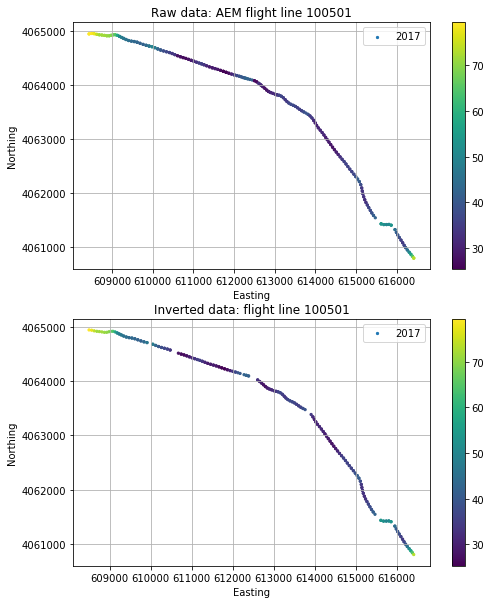

In [169]:
f,axs = plt.subplots(2,1,figsize=(8,10))
plt.sca(axs.flatten()[0])
ax = plt.gca()
plt.scatter(df.loc[df.LINE_NO==line,'UTMX'],
            df.loc[df.LINE_NO==line,'UTMY'],
            s=5,
            c=df.loc[df.LINE_NO==line,'INVALT'],
            label='2017')

plt.grid(True)
plt.colorbar()
plt.legend()
plt.xlabel('Easting')
plt.ylabel('Northing')
plt.title('Raw data: AEM flight line {}'.format(line))



plt.sca(axs.flatten()[1])
ax = plt.gca()
plt.scatter(df17.loc[df17.LINE==line,'X'],
            df17.loc[df17.LINE==line,'Y'],
            s=5,
            c=df17.loc[df17.LINE==line,'INVALT'],
            label='2017')
# plt.scatter(df19.loc[df19.LINE==line,'X'],df19.loc[df19.LINE==line,'Y'],s=1,c='k',label='2019')
plt.grid(True)
plt.colorbar()
plt.legend()
plt.xlabel('Easting')
plt.ylabel('Northing')
plt.title('Inverted data: flight line {}'.format(line))